In [1]:
# Install Ultralytics YOLO and dependencies if missing
import sys, subprocess, importlib

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
        print(f"{pkg} already installed.")
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

ensure('ultralytics')
ensure('opencv-python', 'cv2')

import ultralytics, cv2
print('ultralytics:', ultralytics.__version__)
print('opencv:', cv2.__version__)

import matplotlib.pyplot as plt

ultralytics already installed.
opencv-python already installed.
ultralytics: 8.3.227
opencv: 4.12.0


In [2]:
# Helpers: preprocess and tensor conversions
import os
import torch
import numpy as np
from PIL import Image

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

try:
    import torchvision.transforms as T
except Exception:
    T = None


def load_image(path, to_tensor=True, device=None):
    img = Image.open(path).convert('RGB')
    if to_tensor:
        if T is None:
            raise RuntimeError('torchvision is required to create img_t')
        tfm = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])
        t = tfm(img).unsqueeze(0)
        if device:
            t = t.to(device)
        return t
    else:
        return np.array(img)

def tensor_to_uint8_rgb(img_t):
    # img_t: 1x3xHxW normalized (ImageNet). Return HxWx3 uint8 RGB
    x = img_t.detach().clone().cpu()
    if x.dim() == 4:
        x = x[0]
    # de-normalize
    mean = torch.tensor(IMAGENET_MEAN)[:, None, None]
    std = torch.tensor(IMAGENET_STD)[:, None, None]
    x = x * std + mean
    x = x.clamp(0, 1)
    x = (x.permute(1, 2, 0).numpy() * 255.0).astype(np.uint8)
    return x

In [9]:
# Ensure IM_PATH and img_t exist (downloads a sample if missing)
import urllib.request
from pathlib import Path

IM_PATH = 'data/sample.jpg'
Path('data').mkdir(parents=True, exist_ok=True)
if not os.path.exists(IM_PATH):
    # sample_url = 'https://images.unsplash.com/photo-1760681557777-bfac1f18cf90?auto=format&fit=crop&q=80&w=1024'
    sample_url = 'https://ultralytics.com/images/bus.jpg'
    urllib.request.urlretrieve(sample_url, IM_PATH)

# Create img_t on CPU by default (Ultralytics handles device internally)
img_t = load_image(IM_PATH, to_tensor=True, device='cpu')
print('Image ready at', IM_PATH, 'tensor shape:', tuple(img_t.shape))

plt.figure()
plt.imshow(tensor_to_uint8_rgb(img_t))
plt.axis('off')
plt.show()

HTTPError: HTTP Error 403: Forbidden

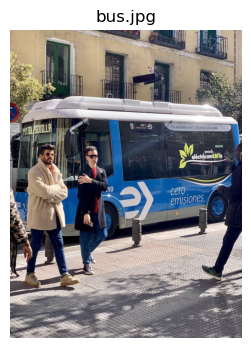

In [13]:
# Load ./data/bus.jpg and plot using plt.imshow
bus_path = 'data/bus.jpg'

if not os.path.exists(bus_path):
    # Try to reuse already downloaded sample
    if os.path.exists(IM_PATH):
        with open(IM_PATH, 'rb') as src, open(bus_path, 'wb') as dst:
            dst.write(src.read())
    else:
        url = sample_url if sample_url.endswith('.jpg') else sample_url + '.jpg'
        urllib.request.urlretrieve(url, bus_path)

rgb = Image.open(bus_path).convert('RGB')
plt.figure(figsize=(6, 4))
plt.imshow(rgb)
plt.axis('off')
plt.title('bus.jpg')
plt.show()

# Ultralytics YOLO: Object Detection
We will run YOLOv8n (pretrained on COCO) on the tensor `img_t`, visualize detections, and show how to access boxes, scores, and classes.

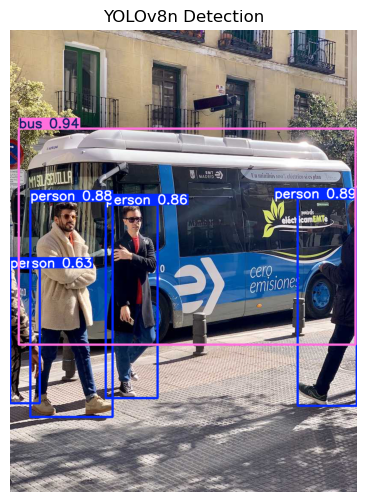

Detections: 5
0: bus 0.94 x1y1x2y2=[ 20 230 806 735]
1: person 0.89 x1y1x2y2=[671 394 809 878]
2: person 0.88 x1y1x2y2=[ 47 399 239 904]
3: person 0.86 x1y1x2y2=[223 408 344 860]
4: person 0.63 x1y1x2y2=[  0 556  69 872]


In [14]:
# Run YOLOv8n detection on img_t
from ultralytics import YOLO
import torch
import cv2
import numpy as np

# Convert normalized img_t back to RGB uint8 for visualization and model input compatibility
# rgb = tensor_to_uint8_rgb(img_t)

# YOLOv8 models accept numpy HxWxC (RGB) directly
model_det = YOLO('yolo11n.pt')  # small, fast COCO model
results = model_det.predict(rgb, imgsz=640, conf=0.25, verbose=False)
res = results[0]

# Ultralytics provides a handy plot
plot_img = res.plot()  # BGR ndarray
plot_img_rgb = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)

# Show
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(plot_img_rgb)
plt.axis('off')
plt.title('YOLOv8n Detection')
plt.show()

# Access boxes
if res.boxes is not None and len(res.boxes) > 0:
    boxes = res.boxes.xyxy.cpu().numpy()  # Nx4
    confs = res.boxes.conf.cpu().numpy()  # N
    clss  = res.boxes.cls.cpu().numpy().astype(int)  # N
    names = res.names
    print('Detections:', len(boxes))
    for i, (xyxy, c, k) in enumerate(zip(boxes, confs, clss)):
        print(f"{i}: {names[k]} {c:.2f} x1y1x2y2={xyxy.astype(int)}")
else:
    print('No detections.')

# Ultralytics YOLO: Instance Segmentation
We will run YOLOv8n-seg on the same image tensor `img_t`, visualize masks, and access polygons/masks programmatically.

In [10]:
# Run YOLOv8n-seg on img_t
from ultralytics import YOLO
import cv2

rgb = tensor_to_uint8_rgb(img_t)
model_seg = YOLO('yolov8n-seg.pt')
results = model_seg.predict(rgb, imgsz=640, conf=0.25, verbose=False)
res = results[0]

# Built-in plot (BGR)
plot_img = res.plot()
plot_img_rgb = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(plot_img_rgb)
plt.axis('off')
plt.title('YOLOv8n-seg Instance Segmentation')
plt.show()

# Access masks and classes
if getattr(res, 'masks', None) is not None and res.masks is not None:
    print('Masks:', res.masks.data.shape)  # [N, H, W]
    clss = res.boxes.cls.cpu().numpy().astype(int)
    confs = res.boxes.conf.cpu().numpy()
    names = res.names
    for i, (k, c) in enumerate(zip(clss, confs)):
        print(f"{i}: {names[k]} {c:.2f}")
else:
    print('No masks found.')

AssertionError: Image not contiguous. Apply np.ascontiguousarray(im) to Annotator input images.